<a href="https://colab.research.google.com/github/IvanSalinas2000/Projects/blob/main/Chatbot%20Medico/ChatbotMedico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rouge-score sacrebleu evaluate torchsummary
!pip install --upgrade transformers sentencepiece
!pip uninstall -y protobuf
!pip install protobuf==3.20.*
!pip install --upgrade transformers datasets

In [1]:
pip install --upgrade nbformat nbconvert

#Proyecto
##Generación Automática de Respuestas para Preguntas Médicas usando T5
###Iván Gabriel Salinas Castillo 1856735

#Modelo

Data Sample:
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data:
question       0
answer         5
source         0
focus_area    14
dtype: int64
Number of duplicate rows: 48
Table Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



Detailed Model Summary:
Layer Type                    Count     Parameters     
T5ForConditionalGeneration    1         222,882,048    
Embedding                     3         24,653,568     
T5Stack                       2         247,534,848    
ModuleList                    26        396,455,424    
T5Block                       24        198,227,712    
T5LayerSelfAttention          24        56,642,304     
T5Attention                   36        84,935,424     
Linear                        193       222,833,664    
T5LayerNorm                   62        47,616         
Dropout                       86        0              
T5LayerFF                     24        113,264,640    
T5DenseActDense               24        113,246,208    
ReLU                          24        0              
T5LayerCrossAttention         12        28,320,768     


Map (num_proc=2):   0%|          | 0/11778 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2079 [00:00<?, ? examples/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
1,1.582300,1.494043,0.139009,0.292695,0.401725


Epoch,Training Loss,Validation Loss,Exact Match,Bleu,Rouge-l
1,1.582300,1.494043,0.139009,0.292695,0.401725
2,1.311900,1.364654,0.145743,0.321735,0.427885


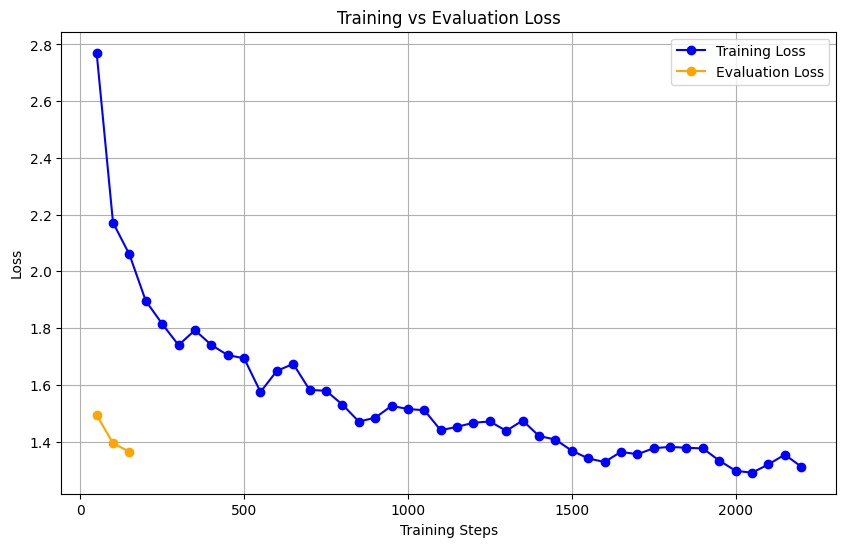

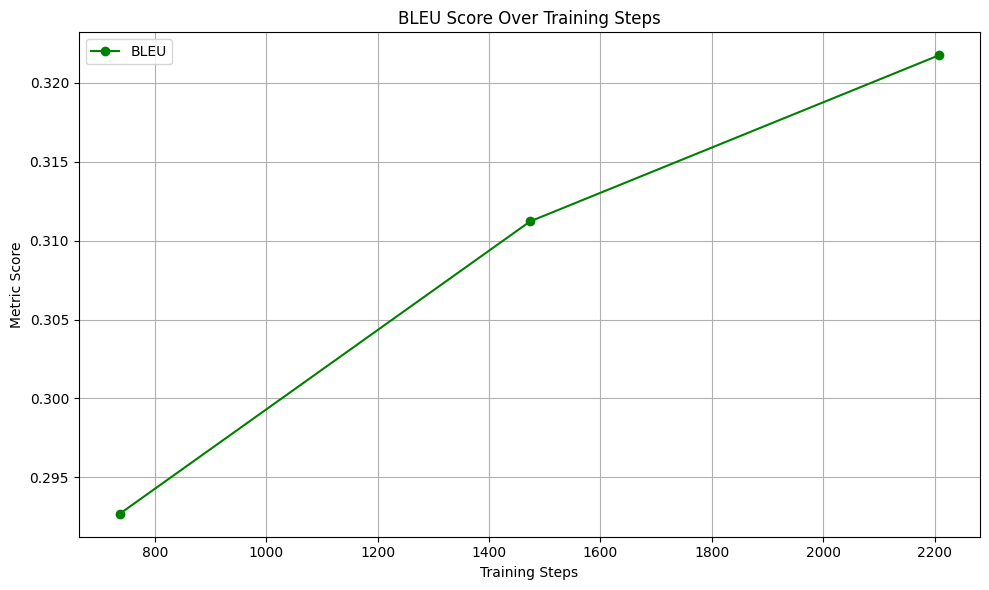

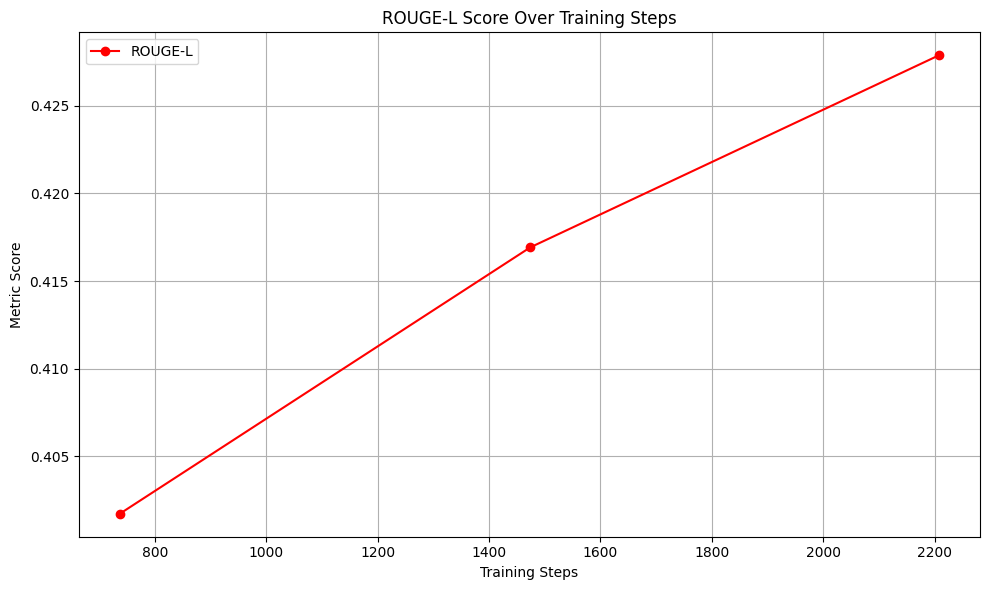

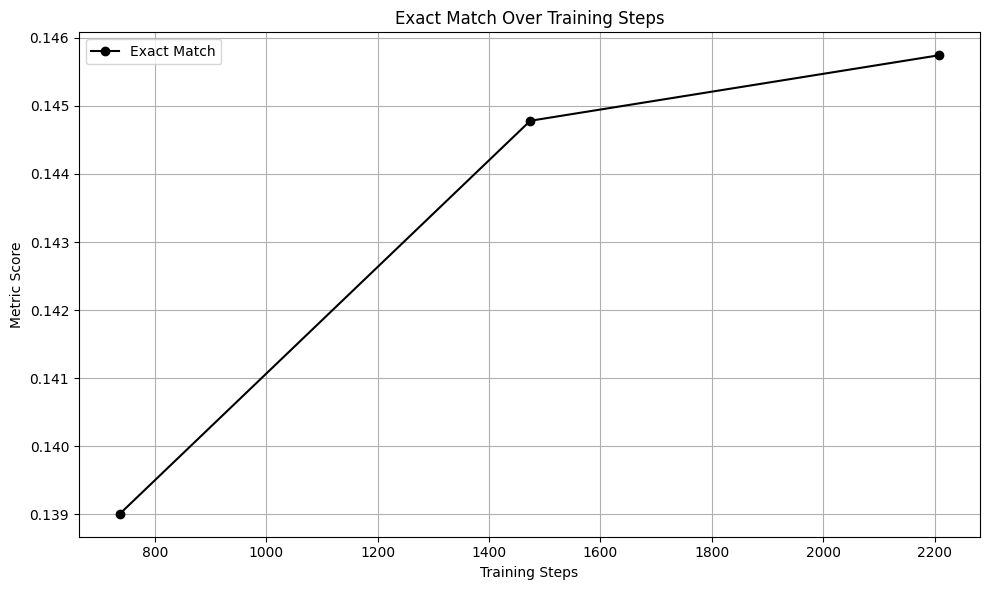

Question: What is Alzheimer's?
Response: Alzheimer's disease is an inherited disease that involves the loss of certain parts of the brain and spinal cord. it is one of the most common forms of intellectual disability. most people with this condition are born with brain abnormalities; their brains, bones, and joints, are prone to stroke and brain


In [ ]:
import torch
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import evaluate
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Bibliotecas de Hugging Face Transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer, DataCollatorForSeq2Seq, TrainerCallback, T5Config

from datasets import Dataset
from sklearn.model_selection import train_test_split

from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset
from torchsummary import summary

from collections import defaultdict

warnings.filterwarnings("ignore")

# Cargar el dataset desde un archivo CSV
df = pd.read_csv('/content/medquad.csv')

print("Muestra de datos:")
print(df.head())
print("Datos con valores nulos:")
print(df.isnull().sum())

# Definir una lista de palabras comunes para hacer preguntas
question_words = ['what', 'who', 'why', 'when', 'where', 'how', 'is', 'are', 'does', 'do', 'can', 'will', 'shall']

# Limpieza de datos
df['question'] = df['question'].str.lower()
df = df[df['question'].str.split().str[0].isin(question_words)]
df = df.reset_index(drop=True)
duplicates = df.duplicated()
print(f"Número de filas duplicadas: {duplicates.sum()}")
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)
df = df.drop(columns=['source', 'focus_area'])

print("Información de la tabla:")
print(df.info())

df = df.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
df = df.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

df = df.dropna(subset=['question', 'answer']).reset_index(drop=True)
df['question'] = df['question'].fillna('').astype(str)
df['answer'] = df['answer'].fillna('').astype(str)

def clean_text(text):
    text = re.sub(r"\(.*?\)", "", text)  # Eliminar texto entre paréntesis
    text = re.sub(r'\s+', ' ', text.strip().lower())  # Normalizar espacios y convertir a minúsculas
    return text


df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

# Limpieza adicional del texto: minúsculas, eliminar espacios y normalizar espacios
df['question'] = df['question'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))
df['answer'] = df['answer'].str.lower().str.strip().apply(lambda x: re.sub(r'\s+', ' ', x))

# Verificar valores nulos después de la limpieza
print("Datos con valores nulos después de la limpieza:")
print(df.isnull().sum())

# Verificar el número de preguntas y respuestas únicas en el dataset
print(f"Preguntas únicas: {df['question'].nunique()}")
print(f"Respuestas únicas: {df['answer'].nunique()}")

# Mostrar información del dataset y una muestra de los datos limpios
print("Información final del dataset:")
df.info()
print("Muestra final de datos:")
df.head()

# Definir el nombre del modelo y cargar la configuración de T5
model_name = "t5-base"
config = T5Config.from_pretrained(model_name)

# Personalizar la configuración
config.dropout_rate = 0.1  # Establecer tasa de dropout en 0.1 para regularización
config.feed_forward_proj = "gelu"  # Usar activación GELU para las capas feed-forward

# Cargar el modelo T5 pre-entrenado con la configuración personalizada
model = T5ForConditionalGeneration.from_pretrained(model_name, config=config)

# Cargar el tokenizador para el modelo T5
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Ajustar explícitamente los embeddings de tokens para que coincidan con el tamaño del vocabulario del tokenizador
model.resize_token_embeddings(len(tokenizer))

# Imprimir un resumen detallado de la arquitectura del modelo
print("\nResumen detallado del modelo:")
print("=" * 50)

def summarize_model_by_type(model):
    """
    Resume el modelo contando el número de capas y parámetros para cada tipo de capa.
    """
    layer_summary = defaultdict(int)  # Cuenta el número de capas por tipo
    param_summary = defaultdict(int)  # Cuenta el número de parámetros por tipo de capa

    for name, module in model.named_modules():
        layer_type = type(module).__name__  # Obtener el tipo del módulo actual
        layer_summary[layer_type] += 1  # Incrementar el contador para este tipo de capa
        param_summary[layer_type] += sum(p.numel() for p in module.parameters())  # Sumar parámetros

    # Imprimir la tabla de resumen
    print(f"{'Tipo de Capa':<30}{'Cantidad':<10}{'Parámetros':<15}")
    print("=" * 55)
    for layer_type, count in layer_summary.items():
        print(f"{layer_type:<30}{count:<10}{param_summary[layer_type]:<15,}")

summarize_model_by_type(model)

# Definir una función de preprocesamiento para la tarea seq2seq
def preprocess_function(batch):
    """
    Preprocesa el dataset tokenizando las entradas y objetivos.
    """
    # Formatear las entradas y objetivos
    inputs = [f"answer the following question: {q}" for q in batch['question']]
    targets = [f"{a}" for a in batch['answer']]

    # Tokenizar las entradas
    model_inputs = tokenizer(
        inputs,
        max_length=128,  # Truncar o rellenar a una longitud máxima de 128
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )

    # Tokenizar los objetivos
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=64,  # Truncar o rellenar a una longitud máxima de 64
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

    # Reemplazar los IDs de tokens de relleno con -100 para que la función de pérdida los ignore
    labels["input_ids"][labels["input_ids"] == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Dividir el dataset en conjuntos de entrenamiento y validación
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42)

# Convertir los DataFrames de pandas a objetos Dataset de Hugging Face
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Preprocesar los datasets de entrenamiento y validación
train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  # Procesar en lotes de 32
    remove_columns=train_dataset.column_names,  # Eliminar columnas originales
    num_proc=2,  # Usar 2 procesos para procesamiento paralelo
)

val_dataset = val_dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,  # Procesar en lotes de 32
    remove_columns=val_dataset.column_names,  # Eliminar columnas originales
    num_proc=4,  # Usar 4 procesos para procesamiento paralelo
)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_total_limit=2,
    learning_rate=3e-4,  # Reducimos la tasa de aprendizaje
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    lr_scheduler_type="linear",  # Cambiamos a lineal
    warmup_ratio=0.1,
    weight_decay=0.05,
    predict_with_generate=True,
    fp16=False,  # Desactivamos fp16 para ver si evita el problema
    logging_dir="./logs",
    logging_steps=50,
    metric_for_best_model="exact_match",
    greater_is_better=True,
    report_to="none",
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,  # Ajustamos la normalización del gradiente
    optim="adamw_torch_fused",
    generation_max_length=64,
    generation_num_beams=6,
    dataloader_num_workers=4,
    group_by_length=True,
    remove_unused_columns=False,  # No eliminar columnas por ahora
    label_smoothing_factor=0.0,  # Desactivamos label smoothing
)

# Inicializar el data collator para tareas seq2seq
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding='longest',  # Rellenar secuencias a la más larga del lote
    return_tensors="pt",  # Devolver tensores de PyTorch
)

# Definir una función para calcular métricas de evaluación
def compute_metrics(eval_pred, tokenizer):
    """
    Calcula las métricas de coincidencia exacta, BLEU y ROUGE-L para evaluación.
    """
    predictions, labels = eval_pred

    # Decodificar predicciones y etiquetas
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Normalizar texto para comparación
    decoded_preds = [text.strip().lower() for text in decoded_preds]
    decoded_labels = [text.strip().lower() for text in decoded_labels]

    # Calcular coincidencia exacta
    exact_match = np.mean([p == l for p, l in zip(decoded_preds, decoded_labels)])

    # Cargar métricas BLEU y ROUGE
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")

    # Calcular puntuación BLEU
    bleu_score = bleu_metric.compute(
        predictions=decoded_preds,
        references=[[label] for label in decoded_labels]
    )["bleu"]

    # Calcular puntuación ROUGE-L
    rouge_score = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )["rougeL"]

    return {
        "exact_match": exact_match,
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
    }

# Inicializar el Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, tokenizer),
)

# Entrenar el modelo
trainer.train()

# Guardar el modelo entrenado y el tokenizador
trainer.save_model("./t5_chatbot_model")
tokenizer.save_pretrained("./t5_chatbot_tokenizer")

# Guardar el diccionario de estado del modelo
model_path = "./t5_chatbot_model.h5"
torch.save(model.state_dict(), model_path)

# Guardar el historial de registro del entrenamiento
log_history = trainer.state.log_history

# Inicializar listas para almacenar métricas de entrenamiento y evaluación
train_loss = []  # Para almacenar valores de pérdida de entrenamiento
eval_loss = []  # Para almacenar valores de pérdida de evaluación
eval_bleu = []  # Para almacenar puntuaciones BLEU durante la evaluación
eval_exact_match = []  # Para almacenar puntuaciones de coincidencia exacta durante la evaluación
eval_rogue = []  # Para almacenar puntuaciones ROUGE-L durante la evaluación
steps = []  # Para almacenar números de pasos de entrenamiento
eval_steps = []  # Para almacenar números de pasos de evaluación

# Extraer métricas del historial de registro de entrenamiento
for log in log_history:
    if "loss" in log:  # Verificar si hay pérdida de entrenamiento en el registro
        train_loss.append(log["loss"])  # Añadir pérdida de entrenamiento
        steps.append(log["step"])  # Añadir el número de paso correspondiente
    if "eval_loss" in log:  # Verificar si hay pérdida de evaluación en el registro
        eval_loss.append(log["eval_loss"])  # Añadir pérdida de evaluación
        eval_steps.append(log["step"])  # Añadir el número de paso correspondiente
    if "eval_BLEU" in log:  # Verificar si hay puntuación BLEU en el registro
        eval_bleu.append(log["eval_BLEU"])  # Añadir puntuación BLEU
    if "eval_ROUGE-L" in log:  # Verificar si hay puntuación ROUGE-L en el registro
        eval_rogue.append(log["eval_ROUGE-L"])  # Añadir puntuación ROUGE-L
    if "eval_exact_match" in log:  # Verificar si hay puntuación de coincidencia exacta en el registro
        eval_exact_match.append(log["eval_exact_match"])  # Añadir puntuación de coincidencia exacta

# Graficar la pérdida de entrenamiento y evaluación
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Pérdida de Entrenamiento", color="blue", marker="o")  # Graficar pérdida de entrenamiento
plt.plot(steps[:len(eval_loss)], eval_loss, label="Pérdida de Evaluación", color="orange", marker="o")  # Graficar pérdida de evaluación
plt.xlabel("Pasos de Entrenamiento")  # Etiqueta del eje X
plt.ylabel("Pérdida")  # Etiqueta del eje Y
plt.title("Pérdida de Entrenamiento vs Evaluación")  # Título del gráfico
plt.legend()  # Mostrar leyenda
plt.grid(True)  # Añadir cuadrícula para mejor legibilidad
plt.show()  # Mostrar el gráfico

# Graficar la puntuación BLEU durante los pasos de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_bleu, label="BLEU", marker="o", linestyle="-", color="green")  # Graficar puntuación BLEU
plt.xlabel("Pasos de Entrenamiento")  # Etiqueta del eje X
plt.ylabel("Puntuación de Métrica")  # Etiqueta del eje Y
plt.title("Puntuación BLEU durante los Pasos de Entrenamiento")  # Título del gráfico
plt.legend()  # Mostrar leyenda
plt.grid(True)  # Añadir cuadrícula para mejor legibilidad
plt.tight_layout()  # Ajustar diseño para mejor espaciado
plt.show()  # Mostrar el gráfico

# Graficar la puntuación ROUGE-L durante los pasos de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_rogue, label="ROUGE-L", marker="o", linestyle="-", color="red")  # Graficar puntuación ROUGE-L
plt.xlabel("Pasos de Entrenamiento")  # Etiqueta del eje X
plt.ylabel("Puntuación de Métrica")  # Etiqueta del eje Y
plt.title("Puntuación ROUGE-L durante los Pasos de Entrenamiento")  # Título del gráfico
plt.legend()  # Mostrar leyenda
plt.grid(True)  # Añadir cuadrícula para mejor legibilidad
plt.tight_layout()  # Ajustar diseño para mejor espaciado
plt.show()  # Mostrar el gráfico

# Graficar la puntuación de coincidencia exacta durante los pasos de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(eval_steps, eval_exact_match, label="Coincidencia Exacta", marker="o", linestyle="-", color="black")  # Graficar puntuación de coincidencia exacta
plt.xlabel("Pasos de Entrenamiento")  # Etiqueta del eje X
plt.ylabel("Puntuación de Métrica")  # Etiqueta del eje Y
plt.title("Coincidencia Exacta durante los Pasos de Entrenamiento")  # Título del gráfico
plt.legend()  # Mostrar leyenda
plt.grid(True)  # Añadir cuadrícula para mejor legibilidad
plt.tight_layout()  # Ajustar diseño para mejor espaciado
plt.show()  # Mostrar el gráfico

# Definir rutas al modelo y tokenizador guardados
model_path = "/content/t5_chatbot_model"
tokenizer_path = "/content/t5_chatbot_tokenizer"

# Cargar el tokenizador desde la ruta guardada
tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)

# Cargar el modelo desde la ruta guardada
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Poner el modelo en modo evaluación
model.eval()

def generate_response_top_k_top_p(
    question, model, tokenizer, max_length=64, top_k=50, top_p=0.95, temperature=1.0
):
    """
    Genera una respuesta a una pregunta dada usando muestreo Top-K y Top-P.

    Args:
        question (str): La pregunta de entrada para generar una respuesta.
        model (T5ForConditionalGeneration): El modelo T5 pre-entrenado.
        tokenizer (T5Tokenizer): El tokenizador para el modelo T5.
        max_length (int): Longitud máxima de la respuesta generada.
        top_k (int): Número de tokens con mayor probabilidad a considerar para muestreo Top-K.
        top_p (float): Umbral de probabilidad acumulativa para muestreo Top-P (núcleo).
        temperature (float): Controla la aleatoriedad en el muestreo (mayor = más aleatorio).

    Returns:
        str: La respuesta generada.
    """
    # Formatear la pregunta para el modelo
    formatted_question = f"Answer the following question: {question}"

    # Tokenizar la pregunta de entrada
    inputs = tokenizer(
        formatted_question,
        return_tensors="pt",  # Devolver tensores de PyTorch
        padding=True,  # Rellenar secuencias a la misma longitud
        truncation=True,  # Truncar secuencias más largas que max_length
        max_length=128,  # Longitud máxima de la secuencia de entrada
    )

    # Generar una respuesta usando muestreo Top-K y Top-P
    outputs = model.generate(
        input_ids=inputs["input_ids"],  # IDs de tokens de entrada
        attention_mask=inputs["attention_mask"],  # Máscara de atención
        max_length=max_length,  # Longitud máxima de la respuesta generada
        do_sample=True,  # Habilitar muestreo en lugar de búsqueda voraz/por haz
        top_k=top_k,  # Muestreo Top-K: considerar los top-k tokens
        top_p=top_p,  # Muestreo Top-P (núcleo): considerar el conjunto más pequeño de tokens con probabilidad acumulativa >= top_p
        temperature=temperature,  # Ajustar aleatoriedad (valores más altos = más aleatorio)
        pad_token_id=tokenizer.pad_token_id,  # ID de token para relleno
    )

    # Decodificar la respuesta generada en una cadena legible
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return response

# Ejemplo de uso de la función
question = "What is Alzheimer's?"
response = generate_response_top_k_top_p(question, model, tokenizer)

# Imprimir la pregunta y la respuesta generada
print("Pregunta:", question)
print("Respuesta:", response)

In [ ]:
# Define una pregunta en inglés
question = "what is glaucoma?"
response = generate_response_top_k_top_p(question, model, tokenizer)
# Imprimir la pregunta y la respuesta generada
print("Question:", question)
print("Response:", response)

# Define una pregunta en inglés
question = "how is cancer?"
response = generate_response_top_k_top_p(question, model, tokenizer)
# Imprimir la pregunta y la respuesta generada
print("Question:", question)
print("Response:", response)

Question: what is glaucoma?
Response: glaucoma is a disease of the retina, which is the light-sensitive layer of the retina. it is also important to have a visual, speech-language, or swallowing retina. some people with glaucoma have a reduced ability to see. other people may have
Question: how is cancer?
Response: cancer is a kind of cell disease. in cancer, it develops in the tissues of the bones, brain, and liver. the cancer can cause your body to make too much or too little of it. this causes you to develop different types of cancer. your body is made up of nerve cells, called


#Estadisticas descriptivas


Estadísticas de longitud:
       q_length  a_length
count  13857.00  13857.00
mean       8.07    200.11
std        2.43    245.79
min        3.00      1.00
25%        6.00     73.00
50%        8.00    137.00
75%       10.00    251.00
max       23.00   3612.00


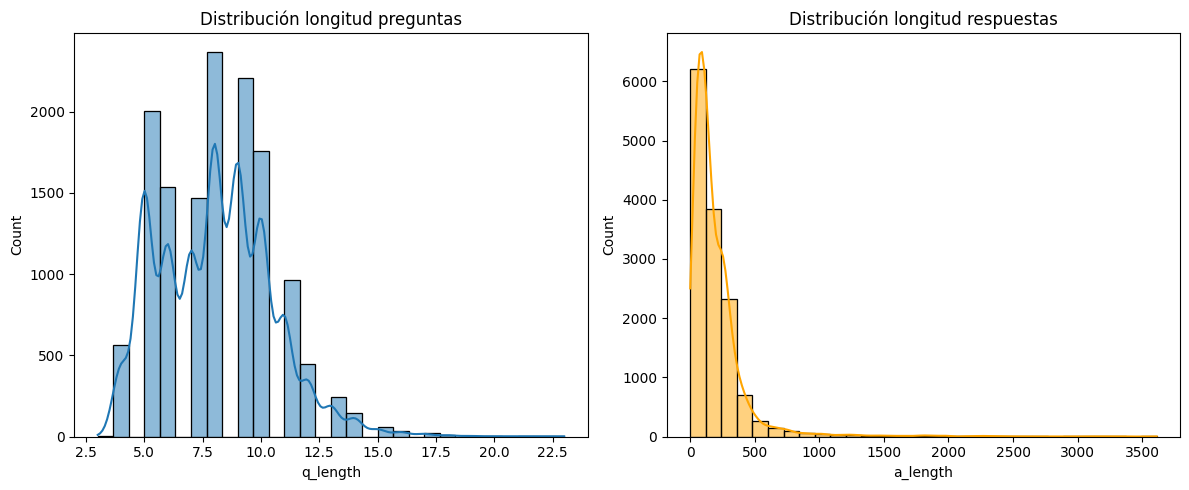


Top 20 palabras en preguntas:
[('?', 13574), ('what', 10634), ('are', 7003), ('the', 6350), ('is', 4993), ('for', 3156), ('of', 3097), ('syndrome', 3083), ('symptoms', 2669), ('to', 2167), ('treatments', 2014), ('how', 1901), ('people', 1118), ('by', 1112), ('many', 1109), ('affected', 1109), ('genetic', 1097), ('related', 1088), ('changes', 1087), ('disease', 1078)]

Top 20 palabras en respuestas:
[('the', 163310), ('of', 106992), ('and', 67188), ('a', 65840), ('in', 59022), ('-', 52850), ('is', 50045), ('to', 47898), ('or', 37251), ('are', 26573), ('that', 26015), ('may', 24947), ('for', 23650), ('with', 23009), ('be', 20010), ('have', 18628), ('people', 17228), ('can', 15976), ('as', 15021), ('these', 14748)]

Distribución de tipos de preguntas:
0
what     0.759544
how      0.136898
is       0.064588
do       0.021289
who      0.017536
where    0.000072
are      0.000072
Name: proportion, dtype: float64


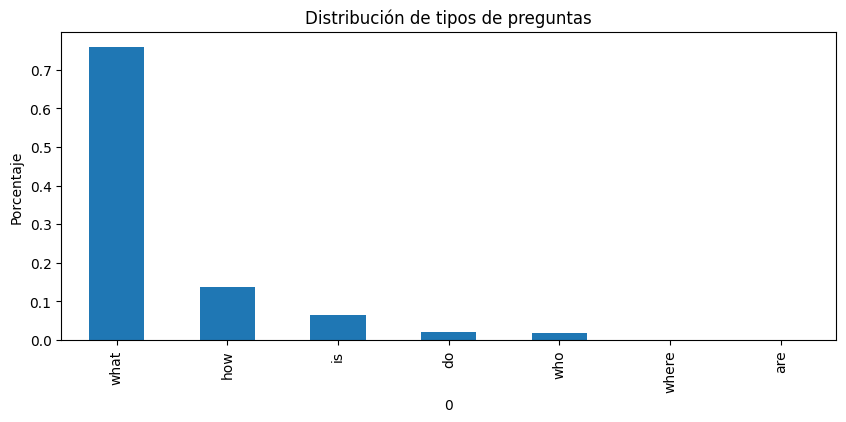


Correlación entre longitud de pregunta y respuesta: 0.06


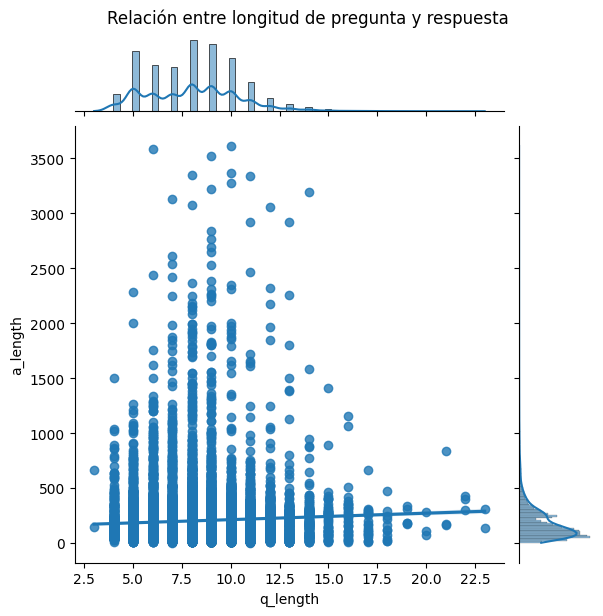


Entidades médicas más frecuentes:
[('nasal bridge', 244), ('nih', 203), ('the national institute of neurological disorders', 139), ('nih: national institute of diabetes', 87), ('nih: national institute of neurological disorders', 47), ('men1', 46), ('fda', 43), ('ttp', 38), ('bmi', 37), ('nih: national institute of allergy', 37), ('cdc', 36), ('nih: national institute of arthritis', 34), ('nasal', 30), ('nih: national institute of child health and human development', 30), ('wilson', 28)]

Distribución por categorías médicas:
diagnosis     3282
treatment     2051
prevention     448
anatomy         88
dtype: int64


In [ ]:
# Longitud de preguntas y respuestas en tokens
df['q_length'] = df['question'].apply(lambda x: len(x.split()))  # Calcular longitud en tokens de preguntas
df['a_length'] = df['answer'].apply(lambda x: len(x.split()))    # Calcular longitud en tokens de respuestas

print("\nEstadísticas de longitud:")
print(df[['q_length', 'a_length']].describe().round(2))

# Visualización de distribuciones de longitud
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['q_length'], bins=30, kde=True)  # Histograma para longitud de preguntas
plt.title('Distribución longitud preguntas')

plt.subplot(1, 2, 2)
sns.histplot(df['a_length'], bins=30, kde=True, color='orange')  # Histograma para longitud de respuestas
plt.title('Distribución longitud respuestas')
plt.tight_layout()
plt.show()

from collections import Counter

# Análisis de palabras más frecuentes
q_words = ' '.join(df['question']).lower().split()  # Unir todas las preguntas y dividir en palabras
q_word_counts = Counter(q_words).most_common(20)    # Contar las 20 palabras más comunes en preguntas

a_words = ' '.join(df['answer']).lower().split()    # Unir todas las respuestas y dividir en palabras
a_word_counts = Counter(a_words).most_common(20)    # Contar las 20 palabras más comunes en respuestas

print("\nTop 20 palabras en preguntas:")
print(q_word_counts)

print("\nTop 20 palabras en respuestas:")
print(a_word_counts)

# Clasificación por palabra inicial de las preguntas
question_types = df['question'].str.extract(r'^(what|who|why|when|where|how|is|are|does|do|can|will)', flags=re.IGNORECASE)[0]
question_dist = question_types.value_counts(normalize=True).sort_values(ascending=False)  # Distribución porcentual

print("\nDistribución de tipos de preguntas:")
print(question_dist)

# Visualización de tipos de preguntas
question_dist.plot(kind='bar', figsize=(10, 4), title='Distribución de tipos de preguntas')
plt.ylabel('Porcentaje')
plt.show()

# Análisis de correlación entre longitudes
correlation = df['q_length'].corr(df['a_length'])  # Calcular correlación
print(f"\nCorrelación entre longitud de pregunta y respuesta: {correlation:.2f}")

# Gráfico de dispersión con línea de regresión
sns.jointplot(x='q_length', y='a_length', data=df, kind='reg', height=6)
plt.suptitle('Relación entre longitud de pregunta y respuesta', y=1.02)
plt.show()

# Procesamiento de lenguaje natural para extraer entidades médicas
import spacy
nlp = spacy.load('en_core_web_sm')  # Cargar modelo de lenguaje en inglés

def extract_entities(text):
    """Extrae entidades médicas relevantes del texto"""
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['DISEASE', 'CHEMICAL', 'ORG']]  # Filtrar por tipos de entidades

# Extraer entidades de preguntas y respuestas
df['q_entities'] = df['question'].apply(extract_entities)  # Entidades en preguntas
df['a_entities'] = df['answer'].apply(extract_entities)    # Entidades en respuestas

# Conteo de entidades médicas más frecuentes
all_entities = [item for sublist in df['a_entities'] for item in sublist]  # Aplanar lista de entidades
entity_counts = Counter(all_entities).most_common(15)  # Top 15 entidades más frecuentes

print("\nEntidades médicas más frecuentes:")
print(entity_counts)

# Definir patrones para clasificación de categorías médicas
patterns = {
    'diagnosis': r'diagnos|signs|symptoms',      # Patrón para diagnóstico
    'treatment': r'treat|therapy|drug|medication', # Patrón para tratamiento
    'prevention': r'prevent|avoid|risk',          # Patrón para prevención
    'anatomy': r'organ|body part|muscle|bone'     # Patrón para anatomía
}

# Clasificar preguntas según categorías médicas
for category, pattern in patterns.items():
    df[category] = df['question'].str.contains(pattern, case=False)  # Búsqueda insensible a mayúsculas

# Conteo de preguntas por categoría médica
category_counts = df[list(patterns.keys())].sum().sort_values(ascending=False)
print("\nDistribución por categorías médicas:")
print(category_counts)